In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import rioxarray
from rasterio import features
import pandas as pd

In [2]:
precip_file = 'ZA_chirps_monthly.nc'
tmax_file = 'ZA_chirts_monthly_tmax.nc'
tmin_file = 'ZA_chirts_monthly_tmin.nc'
cropmask_file = 'ZA_cropmask.tif'
shapefile_path = 'ZA_admin_boundary.shp'

In [3]:
ds_precip = xr.open_dataset(precip_file, engine='h5netcdf')
ds_tmax = xr.open_dataset(tmax_file, engine='h5netcdf')
ds_tmin = xr.open_dataset(tmin_file, engine='h5netcdf')

In [4]:
print("Variables in ds_precip:", ds_precip.data_vars)
print("Variables in ds_tmax:", ds_tmax.data_vars)
print("Variables in ds_tmin:", ds_tmin.data_vars)
print("Time steps in ds_precip:", ds_precip.sizes['time'])
print("Time steps in ds_tmax:", ds_tmax.sizes['time'])
print("Time steps in ds_tmin:", ds_tmin.sizes['time'])

Variables in ds_precip: Data variables:
    precip   (time, latitude, longitude) float32 266MB ...
Variables in ds_tmax: Data variables:
    temp     (time, latitude, longitude) float32 269MB ...
Variables in ds_tmin: Data variables:
    temp     (time, latitude, longitude) float32 269MB ...
Time steps in ds_precip: 519
Time steps in ds_tmax: 526
Time steps in ds_tmin: 526


In [5]:
common_time = np.intersect1d(np.intersect1d(ds_precip['time'].values, ds_tmax['time'].values), ds_tmin['time'].values)
ds_precip = ds_precip.sel(time=common_time)
ds_tmax = ds_tmax.sel(time=common_time)
ds_tmin = ds_tmin.sel(time=common_time)

In [6]:
print("Aligned time steps:", len(common_time))

Aligned time steps: 514


In [7]:
crop_mask = rioxarray.open_rasterio(cropmask_file).squeeze()
crop_mask_data = crop_mask.data
crop_mask_data = np.where(crop_mask_data != 0, 1, np.nan)
crop_mask = xr.DataArray(crop_mask_data, coords=crop_mask.coords, dims=crop_mask.dims)

In [8]:
ds_precip = ds_precip.rio.write_crs("EPSG:4326")
ds_tmax = ds_tmax.rio.write_crs("EPSG:4326")
ds_tmin = ds_tmin.rio.write_crs("EPSG:4326")
crop_mask = crop_mask.rio.reproject_match(ds_precip['precip'])

In [9]:
masked_precip_data = ds_precip['precip'].data * crop_mask.data[np.newaxis, :, :]
masked_tmax_data = ds_tmax['temp'].data * crop_mask.data[np.newaxis, :, :]
masked_tmin_data = ds_tmin['temp'].data * crop_mask.data[np.newaxis, :, :]

In [10]:
masked_precip = xr.DataArray(masked_precip_data, coords=ds_precip['precip'].coords, dims=ds_precip['precip'].dims)
masked_tmax = xr.DataArray(masked_tmax_data, coords=ds_tmax['temp'].coords, dims=ds_tmax['temp'].dims)
masked_tmin = xr.DataArray(masked_tmin_data, coords=ds_tmin['temp'].coords, dims=ds_tmin['temp'].dims)

In [11]:
gdf = gpd.read_file(shapefile_path)

ERROR 1: /lib/x86_64-linux-gnu/libssl.so.3: version `OPENSSL_3.2.0' not found (required by /home/arad/miniconda3/envs/pygmt/lib/gdalplugins/.././libcurl.so.4)
ERROR 1: /lib/x86_64-linux-gnu/libssl.so.3: version `OPENSSL_3.2.0' not found (required by /home/arad/miniconda3/envs/pygmt/lib/gdalplugins/.././libcurl.so.4)


In [12]:
provinces = gdf['ADMIN1']

In [13]:
time_series_data = []
for idx, province in gdf.iterrows():
    geom = province.geometry
    mask = features.geometry_mask([geom],
                                  out_shape=(masked_precip.sizes['latitude'], masked_precip.sizes['longitude']),
                                  transform=masked_precip.rio.transform(),
                                  invert=False)

In [14]:
precip_prov_data = np.where(~mask[np.newaxis, :, :], masked_precip.data, np.nan)
tmax_prov_data = np.where(~mask[np.newaxis, :, :], masked_tmax.data, np.nan)
tmin_prov_data = np.where(~mask[np.newaxis, :, :], masked_tmin.data, np.nan)

In [15]:
precip_prov = xr.DataArray(precip_prov_data, coords=masked_precip.coords, dims=masked_precip.dims).mean(dim=['latitude', 'longitude'])
tmax_prov = xr.DataArray(tmax_prov_data, coords=masked_tmax.coords, dims=masked_tmax.dims).mean(dim=['latitude', 'longitude'])
tmin_prov = xr.DataArray(tmin_prov_data, coords=masked_tmin.coords, dims=masked_tmin.dims).mean(dim=['latitude', 'longitude'])

In [17]:
time_len = len(precip_prov['time'].values)
df_prov = pd.DataFrame({
    'time': precip_prov['time'].values,
    'precip_mean': precip_prov.values,
    'tmax_mean': tmax_prov.values,
    'tmin_mean': tmin_prov.values,
    'province': [province['ADMIN1']] * time_len})
time_series_data.append(df_prov)

In [18]:
time_series_df = pd.concat(time_series_data, ignore_index=True)
print("Time-series data sample:")
print(time_series_df.head())

Time-series data sample:
        time  precip_mean  tmax_mean  tmin_mean province
0 1981-01-01   128.734732  29.758114  20.792989  Limpopo
1 1981-02-01    99.572923  27.530817  19.181968  Limpopo
2 1981-03-01    59.572602  27.793741  17.517689  Limpopo
3 1981-04-01    17.006259  27.895686  15.240135  Limpopo
4 1981-05-01     8.606615  23.749376  10.893603  Limpopo


In [19]:
output_csv = '/home/arad/Desktop/ZA_climate_time_series_by_province.csv'
time_series_df.to_csv(output_csv, index=False)
print(f"Time-series data saved to '{output_csv}'")

Time-series data saved to '/home/arad/Desktop/ZA_climate_time_series_by_province.csv'


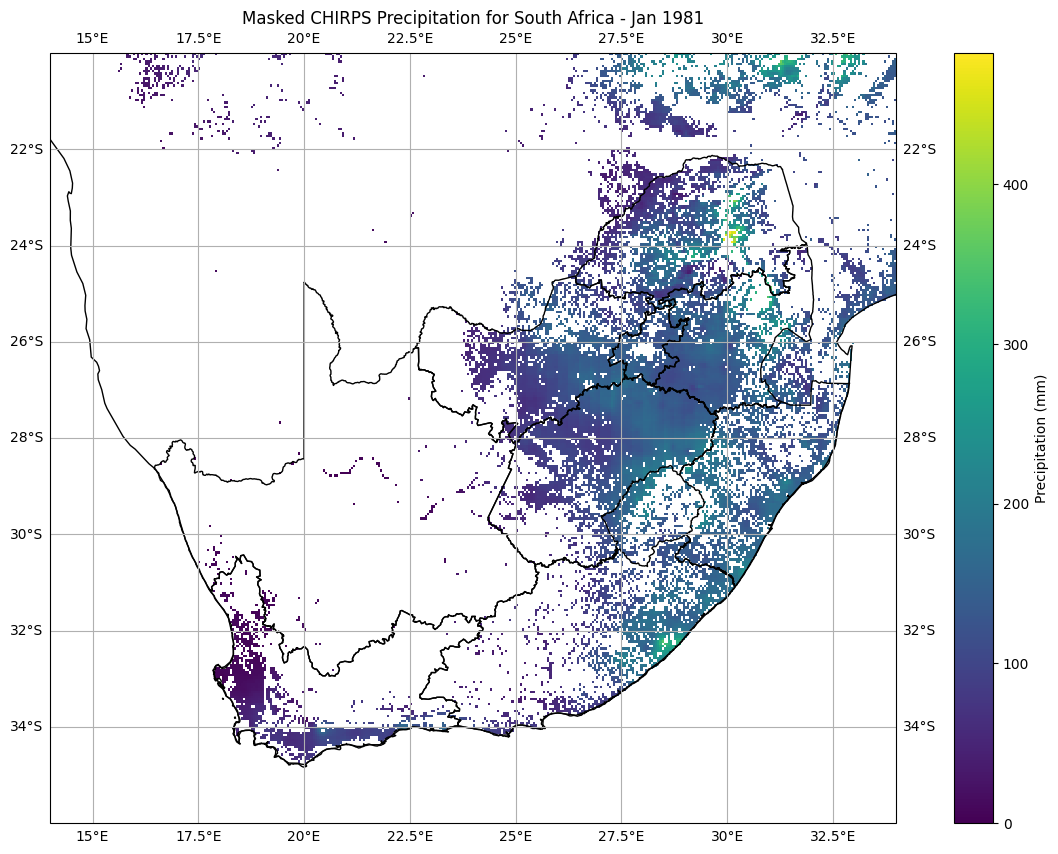

In [20]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
masked_precip.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(),
                                cmap='viridis', cbar_kwargs={'label': 'Precipitation (mm)'})
gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title('Masked CHIRPS Precipitation for South Africa - Jan 1981')
plt.show()